In [3]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import pickle
import numpy as np
import time
import random
import img_lib

/home/kevin/anaconda3/envs/ai4m/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
strokes = ["", "spiral", "box", "triangle", "plus", "circle", "star"]

In [5]:
import importlib
importlib.reload(img_lib)

<module 'img_lib' from '/home/kevin/Documents/dmp_testing/img_lib.py'>

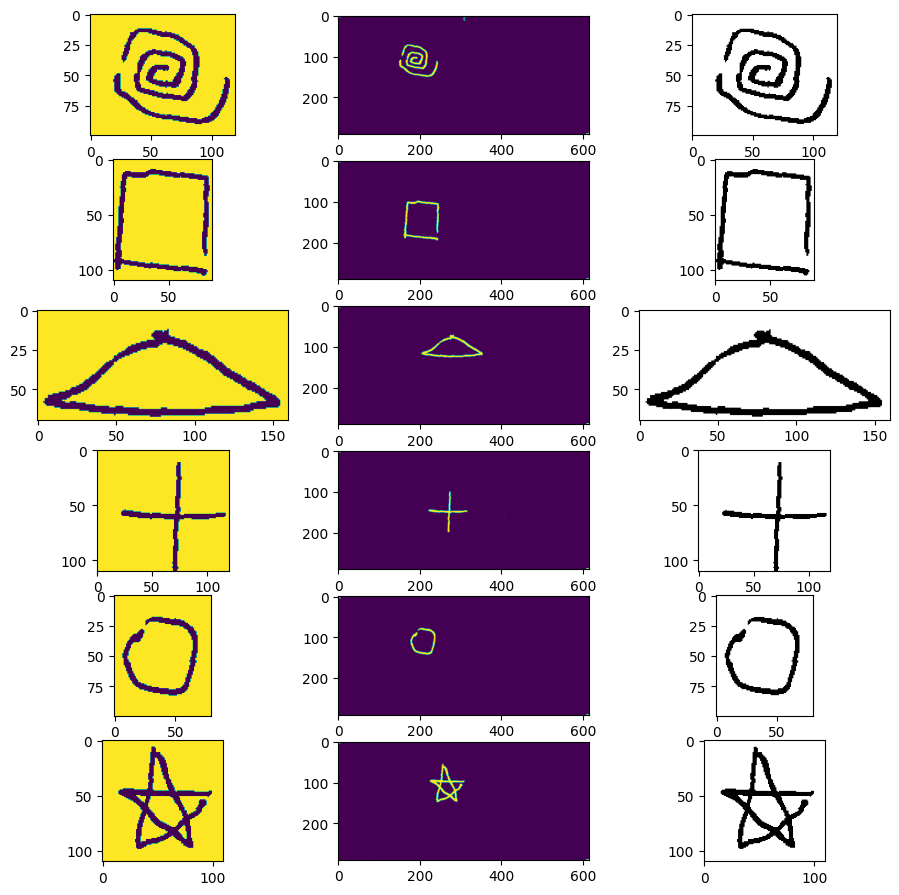

In [6]:
stroke_crops = [
    [[60, 130],[160, 250]],
    [[90, 160],[200, 250]],
    [[60, 200],[130, 360]],
    [[90, 200],[200, 320]],
    [[60, 170],[160, 250]],
    [[50, 210],[160, 320]],
]
out = {}
base = img_lib.prep_img(cv2.imread("corners/0.png"))

out["base"] = base

fig, ax = plt.subplots(6, 3, figsize=(11,11))
for ind, (shape, crops) in enumerate(zip(strokes[1:], stroke_crops)):
    img = cv2.imread(f"{shape}/final.png")
    prepped = img_lib.prep_img(img, base)
    prepped = cv2.cvtColor(prepped, cv2.COLOR_RGB2GRAY)
    ax[ind][0].imshow(img)
    ax[ind][1].imshow(prepped)
    cropped = prepped[crops[0][0]:crops[1][0],crops[0][1]:crops[1][1]]
    _, mask = cv2.threshold(cropped, 200, 255, cv2.THRESH_BINARY)
    cropped = ~cropped
    cropped = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGBA)
    ax[ind][0].imshow(~mask)
    cropped[:,:,3] = mask
    ax[ind][2].imshow(cropped)
    cv2.imwrite(f"strokes/{shape}.png", cropped)
    out[shape] = {
        "img": cropped,
        "label": ind + 1
    }
with open("strokes/data.pkl","wb") as f:
    pickle.dump(out, f)

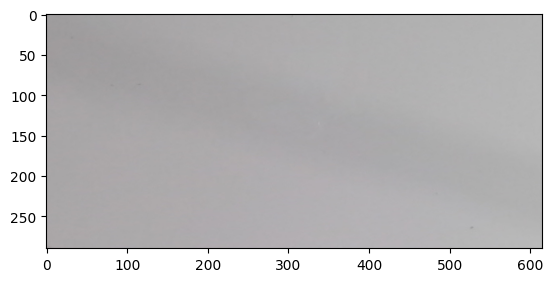

In [7]:
plt.imshow(base)

In [8]:
def do_transform_vanilla(img, base):
    # Set the size of the frame

    label = np.array([[0, 0], [img.shape[0], img.shape[1]]])
    scale = random.uniform(min(base.shape[:2]) / max(img.shape) * 0.3, min(base.shape[:2]) / max(img.shape) *0.4)

    if img.shape[1] > img.shape[0]:
        diff = img.shape[1] - img.shape[0]
        img = np.pad(img, ((diff//2, diff//2), (0, 0), (0, 0)))
        label[:,0] += diff//2
    if img.shape[0] > img.shape[1]:
        diff = img.shape[0] - img.shape[1]
        img = np.pad(img, ((0, 0), (diff//2, diff//2), (0, 0)))
        label[:,1] += diff//2
    
    target_size = (np.array(img.shape) * scale).astype(int)
    diff = target_size - img.shape

    if scale > 1:
        img = np.pad(img, ((diff[0]//2, diff[0]//2), (diff[1]//2, diff[1]//2), (0, 0)))
        label[:,0] += diff[0]//2
        label[:,1] += diff[1]//2
    if scale < 1:
        label = label * scale 
        label += (np.array(img.shape[:2]) * (1-scale)//2)
        label = label.astype(int)
#         label = np.array([[0, 0], target_size[:2]])


    center = (img.shape[0]//2, img.shape[1]//2)
    angle = random.randint(-30, 30)
    rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
    out = cv2.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]))

#     label = np.array([[0, 0], [out.shape[0], out.shape[1]]])
#     label = (label * scale).astype(int)
#     label[:,0] += diff[0]//2
#     label[:,1] += diff[1]//2

    # Hacky label translation
#     rot_mat = cv2.getRotationMatrix2D( center, angle, 1 )
#     inv_rot_mat = np.zeros(rot_mat.shape)
#     cv2.invertAffineTransform(rot_mat, inv_rot_mat)
#     transform_label = np.zeros(label.shape)
#     for i in range(len(label)):
#         transform_label[i] = inv_rot_mat[:, :2] @ label[i] + inv_rot_mat[:, 2]
        
        
#     transform_label = np.array([np.min(label, axis=0), np.max(label, axis=0)])
#     print(center)
#     print(transform_label)
#     dir_to_center = np.zeros(transform_label.shape)
#     dir_to_center[transform_label > center] = -1
#     dir_to_center[transform_label < center] = 1
#     print(dir_to_center)
#     out[center[0]:center[0] + 4, center[1]:center[1]+4] = np.array([255,0,255,255])

#     out[transform_label[0][0]:transform_label[0][0] + 4, transform_label[0][1]:transform_label[0][1]+4] = np.array([0,255,0,255])
#     out[transform_label[1][0]:transform_label[1][0] + 4, transform_label[1][1]:transform_label[1][1]+4] = np.array([0,255,0,255])

#     transform_label = transform_label + dir_to_center * abs((center - transform_label) * (1-scale))
#     print(transform_label)
#     transform_label = transform_label.astype(int)
#     out = out[transform_label[0][0]:transform_label[-1][0], transform_label[0][1]:transform_label[-1][1]]
    transform_label = label
#     out[transform_label[0][0]:transform_label[0][0] + 4, transform_label[0][1]:transform_label[0][1]+4] = np.array([255,0,255,255])
#     out[transform_label[1][0]:transform_label[1][0] + 4, transform_label[1][1]:transform_label[1][1]+4] = np.array([255,0,255,255])
#     plt.imshow(out)
#     plt.show()

    

    # overlay on base img
    base = cv2.cvtColor(base, cv2.COLOR_RGB2RGBA)
    offset_h = random.randint(0, base.shape[0] - out.shape[0])
    offset_w = random.randint(0, base.shape[1] - out.shape[1])  
    base[offset_h:offset_h+out.shape[0], offset_w:offset_w+out.shape[1]] = np.where(out[:,:,3,None] == 0, base[offset_h:offset_h+out.shape[0], offset_w:offset_w+out.shape[1]], out)

    transform_label[:,0] += offset_h
    transform_label[:,1] += offset_w
    transform_label = transform_label.astype(int)
#     base[transform_label[0][0]:transform_label[0][0] + 4, transform_label[0][1]:transform_label[0][1]+4] = np.array([255,0,255,255])
#     base[transform_label[1][0]:transform_label[1][0] + 4, transform_label[1][1]:transform_label[1][1]+4] = np.array([255,0,255,255])
    return base, transform_label


import copy
def overlay(stroke, base):

    base = cv2.cvtColor(base, cv2.COLOR_RGB2RGBA)
    offset_h = random.randint(0, base.shape[0] - stroke.shape[0])
    offset_w = random.randint(0, base.shape[1] - stroke.shape[1])    
    base[offset_h:offset_h+stroke.shape[0], offset_h:offset_h+stroke.shape[1]] = np.where(stroke[:,:,3,None] == 0, base[offset_h:offset_h+stroke.shape[0], offset_h:offset_h+stroke.shape[1]], stroke)
    
    return base
    

[[ 32 395]
 [107 457]]


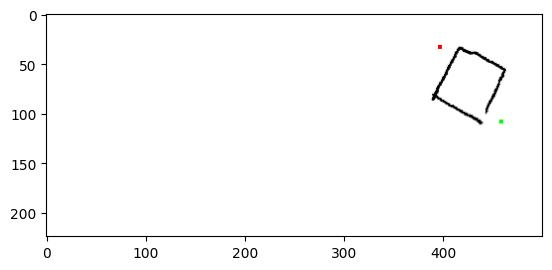

In [9]:
# random.seed(10)

stroke = cv2.imread("strokes/box.png", cv2.IMREAD_UNCHANGED)
smallbase = np.ones((224,500,3), dtype=np.uint8) * 255
img, label = do_transform_vanilla(stroke, smallbase)
print(label)
img[label[0][0]:label[0][0] + 4, label[0][1]:label[0][1]+4] = np.array([255,0,0,255])
img[label[1][0]:label[1][0] + 4, label[1][1]:label[1][1]+4] = np.array([0,255,0,255])

# img = overlay(stroke, base)
plt.imshow(img)


In [11]:
def get_realistic_image(strokes="strokes/data.pkl"):
    with open(strokes, "rb") as f:
        data = pickle.load(f)
    base = data["base"]
#     print(base.shape)
#     base = np.ones((290, 400, 3), dtype=np.uint8) * 255

    for i in range(3):
        item = data[img_lib.STROKES[random.randint(1, len(img_lib.STROKES)-1)]]
        base, coord_labels = do_transform_vanilla(item["img"], base)
        print(coord_labels)
    return base

[[145 408]
 [189 507]]
[[174 344]
 [264 442]]
[[ 73 272]
 [161 377]]


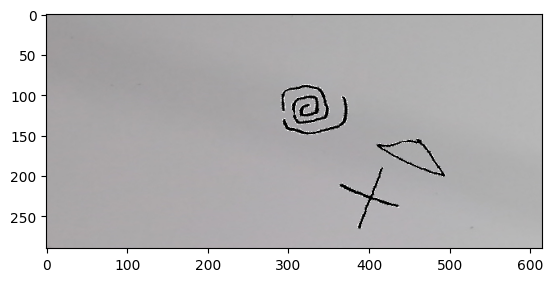

In [12]:
plt.imshow(get_realistic_image())

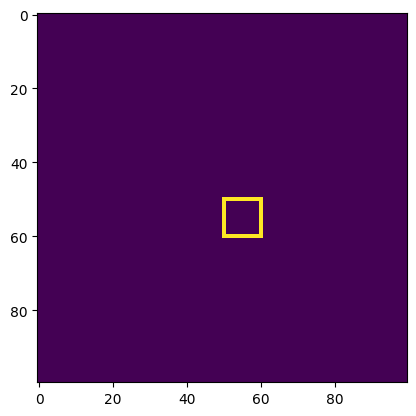

In [13]:
import numpy as np

# create an empty 100x100 array
array = np.zeros((100, 100))

# define the center coordinates of the array
center_x = 50
center_y = 50

# define the starting point for the spiral
start_x = center_x
start_y = center_y

# define the number of loops and the length of each loop
num_loops = 10
loop_length = 10

# create a list of directions for the spiral
directions = ["right", "down", "left", "up"]

# iterate through the number of loops
for loop in range(num_loops):
    # iterate through each direction in the list
    for direction in directions:
        # move in the specified direction for the specified length
        if direction == "right":
            for i in range(loop_length):
                array[start_x + i, start_y] = 1
            start_x += loop_length
        elif direction == "down":
            for i in range(loop_length):
                array[start_x, start_y + i] = 1
            start_y += loop_length
        elif direction == "left":
            for i in range(loop_length):
                array[start_x - i, start_y] = 1
            start_x -= loop_length
        elif direction == "up":
            for i in range(loop_length):
                array[start_x, start_y - i] = 1
            start_y -= loop_length

# print the resulting array
plt.imshow(array*255)

In [ ]:
import numpy as np

# create an empty 100x100 array
array = np.zeros((100, 100))

# define the center coordinates of the array
center_x = 50
center_y = 50

# define the starting point for the spiral
start_x = center_x
start_y = center_y

# define the number of loops and the length of each loop
num_loops = 10
loop_length = 10

# create a dictionary of unit arrays for each direction
directions = {
    "right": np.array([1, 0]),
    "down": np.array([0, 1]),
    "left": np.array([-1, 0]),
    "up": np.array([0, -1]),
}

# iterate through the number of loops
for loop in range(num_loops):
    # iterate through each direction in the dictionary
    for direction, unit_array in directions.items():
        # move in the specified direction for the specified length
        for i in range(loop_length):
            # use the unit array to calculate the coordinates of the next point in the spiral
            x = start_x + unit_array[0]
            y = start_y + unit_array[1]
            # set the value of each cell in the spiral to 1
            array[x, y] = 1
            # update the starting x and y coordinates
            start_x = x
            start_y = y

# print the resulting array
print(array)

In [55]:
import numpy as np

def create_spiral(n_loops=3, start_angle=0):
    # create an empty 100x100 array
    array = np.zeros((100, 100))

    # define the center coordinates of the array
    center_x = 50
    center_y = 50

    # define the radius of the spiral
    r = 1

    # define the number of loops
    num_loops = 3

    k = 2
    # iterate through the radius of the spiral
    theta = np.linspace(start_angle, start_angle + num_loops * 2 * np.pi, 1000)

    x = center_x + r * (k * theta) * np.cos(theta)
    y = center_y + r * (k * theta) * np.sin(theta)
    # round the coordinates to the nearest integer
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    # set the value of each cell in the spiral to 1
    array[x, y] = 1
    array[x+1, y] = 1
    array[x+1, y+1] = 1
    array[x, y+1] = 1

    return array